# Introduction to PyTorch with NLP

PyTorch is a popular open-source deep learning framework developed by Facebook’s AI Research lab that provides flexibility and dynamic computational graphs, making it highly favored for research and production purposes. With its intuitive interface, PyTorch allows developers to build and train complex neural networks with ease.

## Documentation for PyTorch
[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

## Be careful when using tensors.
The location (CPU or GPU) where tensors are located should be taken into consideration.


In [3]:
import torch
import numpy as np

In [4]:
a = torch.ones(3,3)
print(a)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


In [5]:
b = a.numpy()
print(b)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [6]:
# Now changing the value of 'a' will also change the value of 'b'
a.add_(1)
print(a)
print(b)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]


## Using CUDA


1.   Some NLP models will require GPU. For this the tensors need to be properly assigned to the GPU device.
2.   Numpy doesn't support GPU devices hence the tensors need to be




In [7]:
# This gives error
if torch.cuda.is_available():
    device = torch.device("cuda")
    x = torch.ones(5, device=device)
    y = y.to(device)
    z = x + y
    # z = z.to("cpu")
    z.numpy()
    print(z)

### Broadcasting



In [67]:
import torch

# 2D tensor (batch of vectors)
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print("2D Tensor:")
print(tensor_2d)

# 1D tensor (vector)
tensor_1d = torch.tensor([10, 20, 30])
print("1D Tensor:")
print(tensor_1d)

# Broadcasting
result = tensor_2d + tensor_1d
print("Result after broadcasting:")
print(result)

2D Tensor:
tensor([[1, 2, 3],
        [4, 5, 6]])
1D Tensor:
tensor([10, 20, 30])
Result after broadcasting:
tensor([[11, 22, 33],
        [14, 25, 36]])


In [68]:
import torch

# Tensor with shape (2, 3)
tensor_2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print("2D Tensor:")
print(tensor_2d)

# Tensor with shape (2, 2) - This is incompatible for broadcasting
tensor_incompatible = torch.tensor([[10, 20], [30, 40]])
print("Incompatible Tensor:")
print(tensor_incompatible)

try:
    result = tensor_2d + tensor_incompatible
except RuntimeError as e:
    print(f"Error: {e}")

2D Tensor:
tensor([[1, 2, 3],
        [4, 5, 6]])
Incompatible Tensor:
tensor([[10, 20],
        [30, 40]])
Error: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1


## Let's take an example of Multi-Class Classification

### Loading the Dataset

In this step, we load the dataset containing tweets and their associated emotions using the pandas library. The dataset is stored in a CSV file, which we read into a DataFrame for easier manipulation and analysis.

In [61]:
import torch
import torch.nn as nn
import random
import numpy as np
from collections import Counter
import re
import html
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [10]:
import pandas as pd

# Load the CSV file
file_path = 'tweet_emotions.csv'  # Replace with the actual file path if it's different
df = pd.read_csv(file_path)

### Understanding the Data

In this step, we examine the basic characteristics of the dataset. We'll check the structure of the DataFrame, including the column names, data types, and summary statistics. This helps us understand the kind of data we are working with and identify any preprocessing steps that might be necessary.

In [11]:
# Display basic information about the DataFrame
print("DataFrame Info:")
print(df.head())

DataFrame Info:
     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...


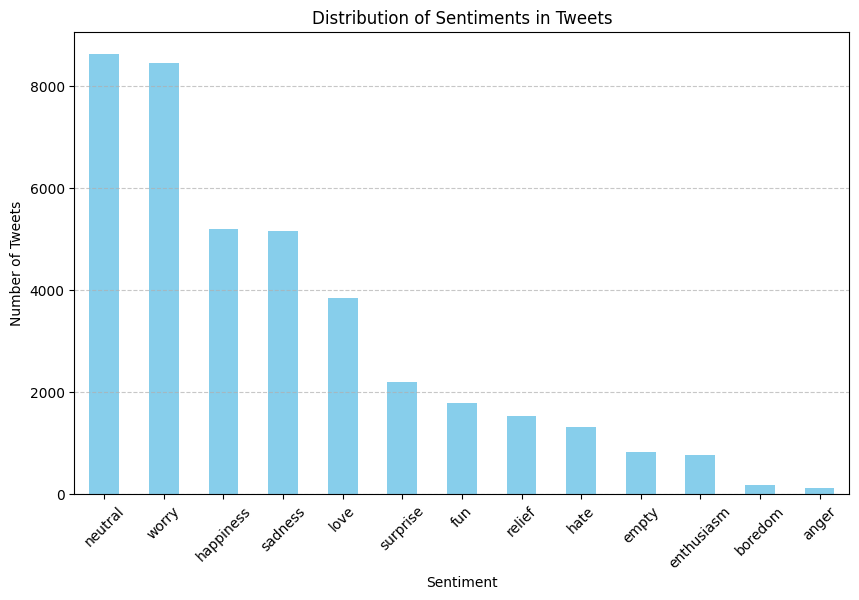

In [12]:
import matplotlib.pyplot as plt

# Count the number of tweets for each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiments in Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preprocessing

Preprocessing is a critical step in Natural Language Processing (NLP) that significantly influences the performance and accuracy of machine learning models. It involves transforming raw text data into a structured format that algorithms can easily interpret and analyze. The primary goal of preprocessing is to clean, normalize, and organize textual data, removing noise and irrelevant details that could mislead the model.

In [13]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with a single space
    s = re.sub(r"\s+", ' ', s)
    # Replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

### Tokenization

Tokenization is a fundamental preprocessing step in Natural Language Processing (NLP) that involves breaking down text into smaller units called tokens, typically words, subwords, or characters. This step is crucial because it transforms raw text into a structured format that can be effectively processed and understood by machine learning models. Tokenization helps capture the syntactic and semantic structure of the text, allowing models to analyze the underlying patterns of language.

In [14]:
def tokenize_df(df, label_column='sentiment'):

    # Tokenize the text (without stop word removal)
    def tokenize_text(text):
        arr = [word for word in text.lower().split()]
        return arr

    df['tokenized'] = df['processed_text'].apply(tokenize_text)

    return df

### Encoding

The encoding step is a critical part of Natural Language Processing (NLP) that transforms raw text data into numerical representations suitable for machine learning models. Since neural networks and other machine learning algorithms cannot process text directly, encoding converts words, sentences, or entire documents into vectors of numbers, enabling models to learn and make predictions. This transformation preserves the semantic meaning and syntactic structure of the language, which is essential for tasks like sentiment analysis, language translation, and text classification.

In [15]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


def encode_labels(df, label_column='sentiment'):
    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Fit and transform the sentiment column
    one_hot_encoded = encoder.fit_transform(df[[label_column]])

    # Convert the one-hot encoded array into integers
    one_hot_encoded_int = one_hot_encoded.astype(int)

    # Convert the one-hot encoded array into a list of vectors
    one_hot_vectors = one_hot_encoded_int.tolist()

    # Optionally: Add the one-hot vectors to the original DataFrame (or return separately)
    df[label_column + '_one_hot'] = one_hot_vectors

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit and transform the sentiment column
    df[label_column + '_label'] = label_encoder.fit_transform(df[label_column])

    return one_hot_vectors, encoder.get_feature_names_out([label_column]), label_encoder

In [16]:
# Preprocess
df['processed_text'] = df['content'].apply(preprocess_string)

# Tokenize
df = tokenize_df(df)

# One-hot and Label encoding
one_hot_vectors, feature_names, label_encoder = encode_labels(df, 'sentiment')

# Drop unnecessary columns
drop_columns = ['tweet_id', 'processed_text']
final_df = df.drop(drop_columns, axis=1)

# Display the DataFrame
print(final_df.head())

    sentiment                                            content  \
0       empty  @tiffanylue i know  i was listenin to bad habi...   
1     sadness  Layin n bed with a headache  ughhhh...waitin o...   
2     sadness                Funeral ceremony...gloomy friday...   
3  enthusiasm               wants to hang out with friends SOON!   
4     neutral  @dannycastillo We want to trade with someone w...   

                                           tokenized  \
0  [tiffanylue, i, know, i, was, listenin, to, ba...   
1  [layin, n, bed, with, a, headache, ughhhhwaiti...   
2                  [funeral, ceremonygloomy, friday]   
3        [wants, to, hang, out, with, friends, soon]   
4  [dannycastillo, we, want, to, trade, with, som...   

                         sentiment_one_hot  sentiment_label  
0  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                2  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]               10  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]               10  
3  [0,

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Where One-Hot Encoding is Useful:

	1.	Input Features for Machine Learning Models: One-hot encoding is essential when categorical features are used as input to models like Logistic Regression, Neural Networks, or SVMs. It prevents models from assuming any ordinal relationship between categories.
	2.	Neural Networks with Softmax and Cross-Entropy Loss: One-hot encoding is required for multi-class classification tasks where the model outputs a probability distribution. It allows for the correct computation of cross-entropy loss by comparing the predicted probabilities against the true distribution.

Where Class Label Encoding is Useful:

	1.	Target Variables in Classification: Label encoding is commonly used for encoding target variables in classification tasks, converting categories into integers that models like Decision Trees, Random Forests, and SVMs can interpret correctly without assuming ordinal relationships.
	2.	Tree-Based Models: Label encoding works well with models like Decision Trees, Random Forests, and Gradient Boosted Trees, as these models treat the labels as distinct categories and do not rely on any numerical order implied by the encoding.

### Example of Softmax and Cross-Entropy with One-Hot Encoding

One-Hot Encoding: Suppose the true sentiment labels are as follows:

* Positive: [1, 0, 0]
* Neutral: [0, 1, 0]
* Negative: [0, 0, 1]

Model Output (Softmax Probabilities):
* For an input, the model predicts probabilities: [0.7, 0.2, 0.1], indicating a high confidence in the “Positive” class.
Cross-Entropy Loss Calculation:
* If the true label is “Positive” ([1, 0, 0]), the cross-entropy loss is calculated using:

$$
\text{Loss} = -\sum (\text{True Label} \times \log(\text{Predicted Probabilities}))
$$

* Substituting the values:

$$
\text{Loss} = -(1 \times \log(0.7) + 0 \times \log(0.2) + 0 \times \log(0.1)) = -\log(0.7)
$$

* This loss indicates how well the predicted probabilities match the true one-hot encoded distribution, guiding the model to improve.


### Some more precautions with softmax
While working with softmax in pytorch, the dim parameter dictates across which dimension the softmax operations is done. Basically, the softmax operation will transform your input into a probability distribution i.e. the sum of all elements will be 1. The below example shows the difference between using dim=0 or dim=1 for a 2D input tensor (supposing the first dimension for the batch size, and the second for the number of classes).

In [17]:
# input tensor of dimensions B x C, B = number of batches, C = number of classes.
inputs = torch.rand(size=(4, 4), dtype=torch.float32)
soft_dim0 = torch.softmax(inputs, dim=0)
soft_dim1 = torch.softmax(inputs, dim=1)
print('**** INPUTS ****')
print(inputs)
print('**** SOFTMAX DIM=0 ****')
print(soft_dim0)
print('**** SOFTMAX DIM=1 ****')
print(soft_dim1)

**** INPUTS ****
tensor([[0.3315, 0.1526, 0.0122, 0.5763],
        [0.0703, 0.7014, 0.6963, 0.2289],
        [0.2301, 0.2791, 0.9236, 0.9237],
        [0.6860, 0.6188, 0.1937, 0.1525]])
**** SOFTMAX DIM=0 ****
tensor([[0.2440, 0.1832, 0.1500, 0.2648],
        [0.1879, 0.3171, 0.2972, 0.1871],
        [0.2204, 0.2079, 0.3730, 0.3748],
        [0.3477, 0.2919, 0.1798, 0.1733]])
**** SOFTMAX DIM=1 ****
tensor([[0.2604, 0.2177, 0.1892, 0.3326],
        [0.1689, 0.3174, 0.3158, 0.1979],
        [0.1652, 0.1735, 0.3306, 0.3306],
        [0.3192, 0.2985, 0.1951, 0.1872]])


As you can see, for the softmax with dim=0, the sum of each column =1, while for dim=1, it is the sum of the rows that equals 1. Usually, you do not want to perform a softmax operation across the batch dimension.

In [18]:
from sklearn.model_selection import train_test_split

# Split the final DataFrame into training and testing sets
train_data, val_data = train_test_split(final_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {val_data.shape}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nTesting Data:")
print(val_data.head())

Training data shape: (32000, 5)
Testing data shape: (8000, 5)

Training Data:
      sentiment                                            content  \
14307   neutral          Thundershowers plus baseball equals awwww   
17812       fun  The Hangover: That movie is gonna be hilarious...   
11020     worry  Playing some games before I leave for work   W...   
15158      hate  About to be stick at work till freakin 2 am.  ...   
24990  surprise  @Sarah_x_ATL u mean jack barakat's?! wow so ha...   

                                               tokenized  \
14307    [thundershowers, plus, baseball, equals, awwww]   
17812  [the, hangover, that, movie, is, gonna, be, hi...   
11020  [playing, some, games, before, i, leave, for, ...   
15158  [about, to, be, stick, at, work, till, freakin...   
24990  [sarah_x_atl, u, mean, jack, barakats, wow, so...   

                             sentiment_one_hot  sentiment_label  
14307  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]                8  
17812  [

### Vocabulary Map

Numerical Representation for PyTorch Models:
* PyTorch models, like all machine learning models, require numerical input. Raw text cannot be directly fed into a model because it consists of characters and words, which are non-numeric.
 * Vocabulary mapping converts text tokens into numerical indices. This numerical representation allows PyTorch models to process and learn from text data.
* PyTorch’s Dataset and DataLoader classes require inputs to be in tensor format for efficient training and evaluation.
 * The vocab map allows for converting text data into numerical tensors, which are compatible with PyTorch’s data structures.

In [19]:
def generate_vocab_map(df, cutoff=2):
    vocab          = {"": 0, "UNK": 1}
    reversed_vocab = None
    # Flatten the list of tokenized words and count their occurrences
    word_counts = {}
    for tokens in df["tokenized"]:
        for word in tokens:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    # Assign unique indices to words that appear more than 'cutoff' times
    word_idx = len(vocab)
    for word, count in word_counts.items():
        if count > cutoff:
            vocab[word] = word_idx
            word_idx += 1

    # Generate the reversed vocab map
    reversed_vocab = {idx: word for word, idx in vocab.items()}

    return vocab, reversed_vocab

In [20]:
train_vocab, reverse_vocab = generate_vocab_map(train_data)

In [21]:
print(train_vocab)

{'': 0, 'UNK': 1, 'plus': 2, 'baseball': 3, 'equals': 4, 'awwww': 5, 'the': 6, 'hangover': 7, 'that': 8, 'movie': 9, 'is': 10, 'gonna': 11, 'be': 12, 'hilarious': 13, 'wish': 14, 'i': 15, 'could': 16, 'see': 17, 'it': 18, 'with': 19, 'crew': 20, 'playing': 21, 'some': 22, 'games': 23, 'before': 24, 'leave': 25, 'for': 26, 'work': 27, 'til': 28, 'at': 29, 'least': 30, 'pm': 31, 'tonight': 32, 'about': 33, 'to': 34, 'stick': 35, 'till': 36, 'freakin': 37, 'am': 38, 'madd': 39, 'suck': 40, 'and': 41, 'worked': 42, 'most': 43, 'day': 44, 'u': 45, 'mean': 46, 'jack': 47, 'wow': 48, 'so': 49, 'have': 50, 'ever': 51, 'gone': 52, 'his': 53, 'house': 54, 'hehe': 55, 'ur': 56, 'lucky': 57, 'address': 58, 'ordered': 59, 'a': 60, 'new': 61, 'computer': 62, 'unfortunately': 63, 'wont': 64, 'get': 65, 'here': 66, 'until': 67, 'end': 68, 'of': 69, 'june': 70, 'hahahah': 71, 'yeah': 72, 'youre': 73, 'right': 74, 'im': 75, 'youll': 76, 'find': 77, 'me': 78, 'all': 79, 'well': 80, 'almost': 81, 'likely'

### Padding
* Text sequences can vary in length (dynamic length sentences), and models typically require fixed-size inputs.
* Using vocabulary maps, you can pad or truncate sequences to a fixed length, which is essential for batch processing in PyTorch. This step is crucial for creating tensors of consistent size.

In [37]:
def pad_or_truncate(tokenized_word_tensor, max_length):
  # Padding or truncating the sequence
  if len(tokenized_word_tensor) < max_length:
      padding_length = max_length - len(tokenized_word_tensor)
      # Pad at the beginning
      tokenized_word_tensor = torch.cat([torch.zeros(padding_length, dtype=torch.long), tokenized_word_tensor])
  else:
      tokenized_word_tensor = tokenized_word_tensor[:max_length]
  return tokenized_word_tensor

### Create Dataset for pytorch
* PyTorch’s Dataset class allows you to define your own custom preprocessing steps, such as tokenization, padding, normalization, and augmentation, directly within the dataset class.
* This ensures that your data is processed consistently and efficiently at the time of loading, making it easy to experiment with different preprocessing strategies.
* The Dataset class works seamlessly with PyTorch’s DataLoader, which handles batching, shuffling, and parallel data loading using multiple workers.


In [38]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, vocab, df, max_length=50):
        self.vocab = vocab
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        # Extract one-hot encoded label
        curr_label = torch.tensor(row["sentiment_one_hot"], dtype=torch.float)

        # Tokenize and convert to tensor indices
        tokenized = row["tokenized"]
        tokenized_word_tensor = torch.tensor([self.vocab.get(word, self.vocab.get('<unk>', 0)) for word in tokenized], dtype=torch.long)

        tokenized_word_tensor = pad_or_truncate(tokenized_word_tensor, self.max_length)

        return tokenized_word_tensor, curr_label

In [39]:
# Assuming train_data and val_data are your DataFrames
train_dataset = SentimentDataset(train_vocab, train_data)
val_dataset = SentimentDataset(train_vocab, val_data)

### Sampler

1.	Improves Model Generalization:
	*	Benefit: By shuffling the data each epoch, RandomSampler helps prevent the model from learning the order of the data, which can cause overfitting.
	*	Impact: This randomness forces the model to learn generalized patterns rather than memorizing the sequence of data points.
2.	Ensures Data Variability in Batches:
	*	Benefit: Random sampling ensures that each batch during training is different, which exposes the model to a diverse set of examples more frequently.
	*	Impact: Diverse batches help the model learn from all parts of the dataset more evenly, improving the training dynamics.
3.	Avoids Bias in Batch Formation:
	*	Benefit: Without random sampling, data points might appear in a biased order, potentially causing the model to train unevenly.
	*	Impact: By shuffling the order, RandomSampler prevents any potential bias related to the order in which data was originally sorted or labeled.
4.	Sampling with Replacement:
	*	Benefit: You can set replacement=True to allow resampling of data points within the same epoch, which is useful for tasks like bootstrapping.
	*	Impact: This setting is particularly valuable when dealing with imbalanced datasets or when implementing specific sampling strategies.

In [40]:
train_sampler = RandomSampler(train_dataset)
val_sampler   = RandomSampler(val_dataset)

### Dataloader

DataLoader is a class in PyTorch’s torch.utils.data module that helps to load data from a dataset in an efficient manner. It manages batching, shuffling, parallel data loading, and more, which are essential for training deep learning models.
*	Batching: Splits the dataset into small batches of data, making it easier for the model to process and update weights iteratively.
*	Shuffling: Allows shuffling of the data to prevent models from learning the order of samples, enhancing model generalization.
*	Parallel Data Loading: Supports loading data in parallel using multiple CPU workers, which speeds up the data loading process.
*	Custom Sampling: Works seamlessly with custom samplers like RandomSampler to control how data points are selected.

Padding and Collate Functions:
*	Benefit: The collate_fn parameter allows for custom logic when merging samples into a batch, such as padding sequences to the same length for NLP tasks.
*	Impact: This customization is vital for working with variable-length data and ensures consistent tensor shapes across batches.

In [44]:
def pad_sequences_front(batch):
    max_len = max(len(seq) for seq in batch)
    padded_batch = torch.zeros((len(batch), max_len), dtype=torch.long)

    for i, seq in enumerate(batch):
        padded_batch[i, -len(seq):] = seq  # Fill the tensor from the end
    return padded_batch

In [45]:
def collate_fn(batch):
    texts, labels = zip(*batch)  # Unpack the batch into texts and labels
    padded_texts = pad_sequences_front(texts)  # Pad sequences to the maximum length
    labels = torch.stack(labels, dim=0)  # Stack labels into a tensor
    return padded_texts, labels

In [46]:
train_iterator = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, collate_fn=collate_fn)
val_iterator   = DataLoader(val_dataset, batch_size=128, sampler=val_sampler, collate_fn=collate_fn)

In [47]:
torch.set_printoptions(threshold=torch.inf, edgeitems=1000, linewidth=1000)
for x, y in train_iterator:
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')
    # print(x)
    # print(y)
    break

x: torch.Size([128, 50])
y: torch.Size([128, 13])


### Early Stopping

Early Stopping is a popular regularization technique used in machine learning to prevent overfitting during the training of models, particularly neural networks. It works by monitoring the performance of the model on a validation set and halting the training process when the model’s performance starts to degrade, indicating that further training would lead to overfitting rather than improvements.

In [48]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = -val_loss
        if score < self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### How to use checkpoints to load models

Implementing a mechanism to resume training from saved checkpoints is a highly beneficial practice in machine learning and deep learning, particularly when working with large and complex models. This approach involves saving the model’s state, optimizer state, and other necessary parameters at various stages of training, allowing you to restart the training process from a saved checkpoint rather than starting from scratch.

* Due to limited availability of GPUs on Google Colab, the code runtime often terminates. Saving a model checkpoint and using it to resume training helps a lot.

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, data):
        self.texts = data['tokenized']
        self.labels = data['sentiment_one_hot']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Use the output of the last time step
        x = self.fc(x)
        return x

In [65]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, checkpoint_path='best_model_checkpoint.pth', resume=False, patience=5):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    start_epoch = 0
    best_val_loss = float('inf')  # Initialize the best validation loss to a large number

    # Resume from checkpoint if needed
    if resume and checkpoint_path:
        try:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint['best_val_loss']
            print(f"Resuming training from epoch {start_epoch} with best validation loss {best_val_loss:.4f}...")
        except FileNotFoundError:
            print(f"No checkpoint found at {checkpoint_path}. Starting training from scratch.")
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting training from scratch.")

    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch.float())
                val_loss += loss.item() * x_batch.size(0)

        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save the best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            print(f"New best model saved with validation loss {best_val_loss:.4f}")

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Plot losses
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example of usage
vocab_size = len(train_vocab)  # Assuming `train_vocab` contains the size of vocabulary
embed_size = 100
hidden_size = 128
output_size = 13  # Number of classes

model = RNNModel(vocab_size, embed_size, hidden_size, output_size)

### Importance of using loss curves to monitor training of model

Monitoring the train and validation loss curves during model training is crucial for understanding the learning dynamics of a machine learning model. These curves provide valuable insights into how well the model is learning from the data and whether it is generalizing effectively to unseen data. Analyzing these curves helps identify potential issues such as overfitting, underfitting, or improper training dynamics, allowing for timely adjustments to the model, training procedure, or data preprocessing.

Key Reasons Why Monitoring Loss Curves is Important

1.	Detecting Overfitting and Underfitting
	*	Overfitting: Overfitting occurs when the model learns the training data too well, including noise and specific patterns that do not generalize to new data. This is typically seen when the training loss continues to decrease while the validation loss starts increasing, indicating that the model is becoming too complex and is memorizing the training data rather than learning generalizable patterns.
	*	Underfitting: Underfitting occurs when the model is too simple to capture the underlying patterns in the data, resulting in both high training and validation losses. The loss curves will show high values without significant improvement, indicating that the model or its training strategy needs to be revised.
2.	Assessing Model Performance and Learning Progress
	*	Monitoring loss curves helps assess whether the model is learning effectively. A steadily decreasing training and validation loss suggests that the model is improving and learning useful patterns from the data.
	*	The shape of the loss curves also provides insights into the learning rate’s suitability; for example, a very steep drop in loss followed by a plateau could indicate an initially high learning rate that quickly stabilizes.
3.	Identifying Training Instabilities
	*	Instabilities in the training process, such as sudden spikes or oscillations in the loss curves, can indicate problems like inappropriate learning rates, improper batch sizes, or noisy data. These fluctuations signal that adjustments are necessary to stabilize the learning process.
	*	A sharp drop followed by a rapid increase in validation loss can indicate the learning rate is too high, causing the model to overshoot the optimal weights.
4.	Optimizing Hyperparameters
	*	The loss curves provide feedback that is crucial when tuning hyperparameters such as learning rate, batch size, model architecture, and regularization terms. For example, if validation loss decreases but then starts to diverge from the training loss, adding regularization or adjusting learning rates may help.
	*	Proper monitoring helps fine-tune these parameters dynamically, leading to faster convergence and better model performance.

Epoch 1/10, Train Loss: 0.2600, Val Loss: 0.2343
Epoch 2/10, Train Loss: 0.2315, Val Loss: 0.2276
Epoch 3/10, Train Loss: 0.2221, Val Loss: 0.2214
Epoch 4/10, Train Loss: 0.2151, Val Loss: 0.2197
Epoch 5/10, Train Loss: 0.2102, Val Loss: 0.2180
Epoch 6/10, Train Loss: 0.2061, Val Loss: 0.2187
Early stopping triggered at epoch 6


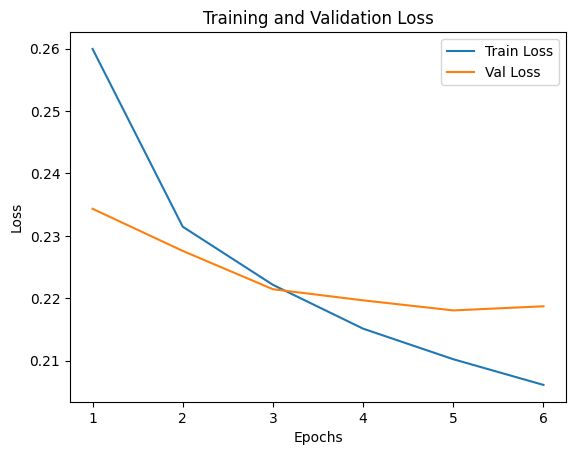

In [ ]:
# To start training from scratch
train_model(model, train_iterator, val_iterator)

In [ ]:
# To resume training from a checkpoint
train_model(model, train_iterator, val_iterator, epochs=11, resume=True)